In [3]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-17.0.2"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt; t = Okt()
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action = 'ignore')

In [23]:
review_data = pd.read_csv('./review_data.csv')
review_data

,name,score,review
0,깐부치킨 강남구청역3번출구점,2,맛도 평균이하이고 좀 불친절함 장소나 넓은것 야외로 오픈되어있는건 좋은데
1,광주식당,4,신선 깔끔함 카드 됨
2,광주식당,1,"현금 없으면 가지 마세요, 현금만 받는다고 공지를 하던까? 맛있게 잘 먹고 당황함.^^♡"
3,컨트롤브이,5,사장님도 정말 친절하시고 음료도 맛있어요 카페도 엄청 깔끔하구요.. 무엇보다 하루가...
4,고향집,5,여기 황태탕은… 정말 최고임
...,...,...,...
2914,인터랙트,1,뜨아는 바로 가져갔는데도 차갑고 바닐라라떼도 무슨맛인지 뜨뜨미지근 값은 너무 비쌈
2915,인터랙트,1,무설탕 글루텐프리여도 맛이없으면 무슨소용… 케이크가 너무 맛이없네요…
2916,인터랙트,1,NaN
2917,인터랙트,1,케이크 너무 맛없어서 놀랬어요…


In [24]:
review_data.isna().sum()

name        0
score       0
review    499
dtype: int64

In [25]:
review_data = review_data.dropna(how='any')
review_data.isna().sum()

name      0
score     0
review    0
dtype: int64

In [26]:
review_data

,name,score,review
0,깐부치킨 강남구청역3번출구점,2,맛도 평균이하이고 좀 불친절함 장소나 넓은것 야외로 오픈되어있는건 좋은데
1,광주식당,4,신선 깔끔함 카드 됨
2,광주식당,1,"현금 없으면 가지 마세요, 현금만 받는다고 공지를 하던까? 맛있게 잘 먹고 당황함.^^♡"
3,컨트롤브이,5,사장님도 정말 친절하시고 음료도 맛있어요 카페도 엄청 깔끔하구요.. 무엇보다 하루가...
4,고향집,5,여기 황태탕은… 정말 최고임
...,...,...,...
2913,인터랙트,3,"치즈케이크, 커피 맛있어요! 앙버터스콘은 쏘쏘"
2914,인터랙트,1,뜨아는 바로 가져갔는데도 차갑고 바닐라라떼도 무슨맛인지 뜨뜨미지근 값은 너무 비쌈
2915,인터랙트,1,무설탕 글루텐프리여도 맛이없으면 무슨소용… 케이크가 너무 맛이없네요…
2917,인터랙트,1,케이크 너무 맛없어서 놀랬어요…


In [27]:
review_data['label'] = np.select([review_data.score > 3], [1], default=0)
review_data[:5]

,name,score,review,label
0,깐부치킨 강남구청역3번출구점,2,맛도 평균이하이고 좀 불친절함 장소나 넓은것 야외로 오픈되어있는건 좋은데,0
1,광주식당,4,신선 깔끔함 카드 됨,1
2,광주식당,1,"현금 없으면 가지 마세요, 현금만 받는다고 공지를 하던까? 맛있게 잘 먹고 당황함.^^♡",0
3,컨트롤브이,5,사장님도 정말 친절하시고 음료도 맛있어요 카페도 엄청 깔끔하구요.. 무엇보다 하루가...,1
4,고향집,5,여기 황태탕은… 정말 최고임,1


In [28]:
# 고유값 확인
review_data['score'].nunique(), review_data['review'].nunique(), review_data['label'].nunique()

(5, 1524, 2)

In [29]:
# 중복 삭제
review_data.drop_duplicates(subset=['review'], inplace=True)
len(review_data)

1524

In [30]:
review_data.isnull().values.any()

False

In [31]:
# 데이터 분리
train_data, test_data = train_test_split(review_data, test_size = 0.25, random_state = 42)
len(train_data), len(test_data)

(1143, 381)

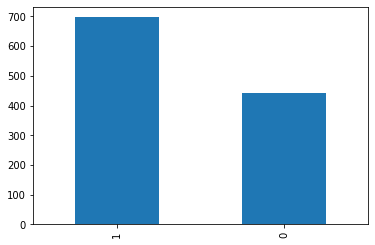

In [60]:
# 데이터 분포
train_data['label'].value_counts().plot(kind = 'bar')

In [33]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,445
1,1,698


In [34]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['review'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

name      0
score     0
review    4
label     0
dtype: int64

In [35]:
train_data = train_data.dropna(how='any')
train_data.isnull().sum(), len(train_data)

(name      0
 score     0
 review    0
 label     0
 dtype: int64, 1139)

In [36]:
test_data.drop_duplicates(subset = ['review'], inplace=True)
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['review'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
test_data.isnull().sum(), len(test_data)

(name      0
 score     0
 review    0
 label     0
 dtype: int64, 380)

In [37]:
# 토큰화 검사
t.morphs('정상에 선 기쁨을 다른 사람들과 함께 나누자')

['정상', '에', '선', '기쁨', '을', '다른', '사람', '들', '과', '함께', '나누자']

In [38]:
# 수제 불용어
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [39]:
train_data['tokenized'] = train_data['review'].apply(t.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [40]:
test_data['tokenized'] = test_data['review'].apply(t.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [41]:
# 긍정과 부정에 따른 단어의 빈도수
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [42]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 128), ('안', 99), ('너무', 82), ('만', 64), ('가격', 61), ('음식', 48), ('으로', 44), ('직원', 44), ('그냥', 42), ('에서', 41), ('하고', 41), ('사람', 39), ('분', 39), ('곳', 36), ('양', 35), ('손님', 35), ('요', 34), ('때', 34), ('별로', 33), ('로', 33)]


In [43]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛', 142), ('너무', 109), ('맛있어요', 100), ('최고', 63), ('님', 61), ('잘', 58), ('진짜', 58), ('맛집', 55), ('으로', 54), ('곳', 54), ('요', 51), ('가격', 49), ('에서', 46), ('로', 45), ('집', 43), ('사장', 42), ('여기', 42), ('맛있고', 41), ('입니다', 41), ('안', 39)]


긍정 리뷰의 평균 길이 : 13.477761836441895
부정 리뷰의 평균 길이 : 21.626696832579185


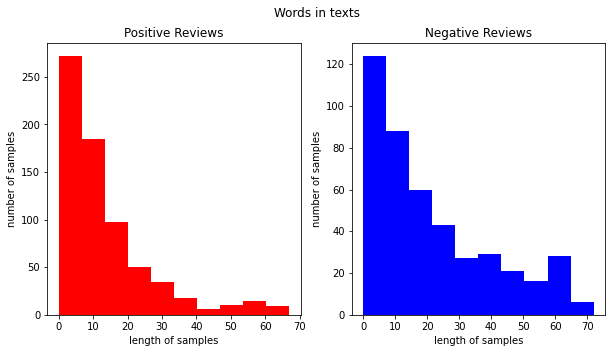

In [44]:
# 긍정과 부정에 따른 길이 분포
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [45]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [47]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5803
등장 빈도가 1번 이하인 희귀 단어의 수: 3642
단어 집합에서 희귀 단어의 비율: 62.760641047733934
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 19.215955257742838


In [48]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
vocab_size

2163

In [49]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
print(X_train[:3])

[[262, 59, 1], [1], [234, 465, 175, 41, 551, 815, 466, 1, 2, 6]]


In [51]:
print(X_test[:3])

[[202, 34, 175, 883, 24, 12, 1, 164], [261, 1, 1, 18, 1, 844, 331, 127, 549, 76, 1, 635, 516, 723, 8, 1, 1, 391, 215, 77, 215, 77, 215, 77, 1, 116, 1, 94, 66, 1162, 1, 116, 230, 214, 15, 526, 131, 1, 256, 1, 490, 340, 972, 476, 1, 959, 478, 63, 104, 1187, 1, 808, 1, 49, 1, 136, 63], [19, 345, 14, 1, 28, 1, 146, 65, 1, 1, 1681, 901, 1, 460, 1, 244, 136, 345, 98, 590, 219, 1, 1076, 1, 450, 1, 127, 11, 1317, 1, 263, 28, 1, 1, 1923, 17, 28, 782, 1, 83, 1520, 104, 748, 1, 146, 626, 92, 1, 263, 28, 104, 1, 1]]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 16.640035118525024


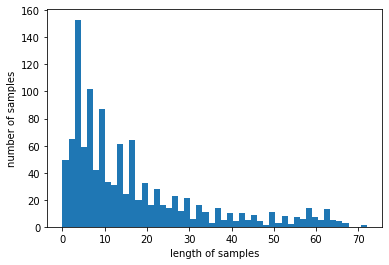

In [52]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [54]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [55]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [56]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.6659 - acc: 0.5851
Epoch 1: val_acc improved from -inf to 0.67982, saving model to best_model.h5
15/15 [==============================] - 5s 169ms/step - loss: 0.6659 - acc: 0.5851 - val_loss: 0.6121 - val_acc: 0.6798
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.5581 - acc: 0.7497
Epoch 2: val_acc improved from 0.67982 to 0.70614, saving model to best_model.h5
15/15 [==============================] - 2s 133ms/step - loss: 0.5581 - acc: 0.7497 - val_loss: 0.9670 - val_acc: 0.7061
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.4396 - acc: 0.8266
Epoch 3: val_acc improved from 0.70614 to 0.71053, saving model to best_model.h5
15/15 [==============================] - 2s 135ms/step - loss: 0.4396 - acc: 0.8266 - val_loss: 0.5540 - val_acc: 0.7105
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.2927 - acc: 0.8880
Epoch 4: val_acc improved from 0.71053 to

In [57]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

12/12 [==============================] - 1s 18ms/step - loss: 0.4593 - acc: 0.7711

 테스트 정확도: 0.7711


In [58]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = t.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [59]:
sentiment_predict('너무 맛있어서 토했어요')

67.33% 확률로 긍정 리뷰입니다.


In [71]:
sentiment_predict('너무 맛있어서 쓰레기통에 잘 넣어 놨어요')

92.17% 확률로 긍정 리뷰입니다.


In [72]:
sentiment_predict('이 맛을 혼자만 느낄 수 없어 비둘기한테 줬더니 맛있게 먹었어요')

84.35% 확률로 긍정 리뷰입니다.
